In [516]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import os

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Dataset Context : 

## Context
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

## Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

# The data set includes information about:

Customers who left within the last month – the column is called Churn
Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents


## Column Metadata  :

| Column | Description | Potential Values |
| :--- | :--- | :--- |
| **customerID** | Unique identifier for the customer | String |
| **gender** | Whether the customer is a male or a female | Male, Female |
| **SeniorCitizen** | Whether the customer is a senior citizen or not | 1, 0 |
| **Partner** | Whether the customer has a partner or not | Yes, No |
| **Dependents** | Whether the customer has dependents or not | Yes, No |
| **tenure** | Number of months the customer has stayed with the company | Numeric |
| **PhoneService** | Whether the customer has a phone service or not | Yes, No |
| **MultipleLines** | Whether the customer has multiple lines or not | Yes, No, No phone service |
| **InternetService** | Customer’s internet service provider | DSL, Fiber optic, No |
| **OnlineSecurity** | Whether the customer has online security or not | Yes, No, No internet service |
| **OnlineBackup** | Whether the customer has online backup or not | Yes, No, No internet service |
| **DeviceProtection** | Whether the customer has device protection or not | Yes, No, No internet service |
| **TechSupport** | Whether the customer has tech support or not | Yes, No, No internet service |
| **StreamingTV** | Whether the customer has streaming TV or not | Yes, No, No internet service |
| **StreamingMovies** | Whether the customer has streaming movies or not | Yes, No, No internet service |
| **Contract** | The contract term of the customer | Month-to-month, One year, Two year |
| **PaperlessBilling** | Whether the customer has paperless billing or not | Yes, No |
| **PaymentMethod** | The customer’s payment method | Electronic check, Mailed check, Bank transfer, Credit card |
| **MonthlyCharges** | The amount charged to the customer monthly | Numeric |
| **TotalCharges** | The total amount charged to the customer | Numeric |
| **Churn** | Whether the customer churned or not | Yes, No |


In [517]:
# Load data from the correct place and check for errors when loading

file_path = os.path.join('..','datasets','telco-churn-dataset.csv') # The .. to move one level up and search the path

try : 
    df = pd.read_csv(file_path)
except FileNotFoundError as f:
    raise('File path not found please check : #_#')
except Exception as e :
    raise(f'Unexpected error occured : {e}')


In [518]:
df.shape # We got 21 columns and 7043 rows to work with

(7043, 21)

In [519]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [520]:
df.dtypes.value_counts() # <-- What dtypes are we working with 

str        18
int64       2
float64     1
Name: count, dtype: int64

In [521]:
df.columns
# These are different attirbutes which will be used to find which one affects the churning rate of the customers the most.

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='str')

In [522]:
df.head() 

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [523]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [524]:
# No anamolies detected till now 

In [525]:
# I will dropping customer_id rightnow in the beggining as I think it wont contribute anything to the model at all
df = df.drop(columns=['customerID'])

In [526]:
df.info() # This dataset is clean and there is no missing values to impute . # Good!!!

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   str    
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   str    
 3   Dependents        7043 non-null   str    
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   str    
 6   MultipleLines     7043 non-null   str    
 7   InternetService   7043 non-null   str    
 8   OnlineSecurity    7043 non-null   str    
 9   OnlineBackup      7043 non-null   str    
 10  DeviceProtection  7043 non-null   str    
 11  TechSupport       7043 non-null   str    
 12  StreamingTV       7043 non-null   str    
 13  StreamingMovies   7043 non-null   str    
 14  Contract          7043 non-null   str    
 15  PaperlessBilling  7043 non-null   str    
 16  PaymentMethod     7043 non-null   str    
 17  Monthl

In [527]:
df.describe(include='all') 

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6531,2
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,20.2,No
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [528]:
# Analyzing the numerical data 

In [529]:
numeric_columns = df.select_dtypes(include='number').columns.to_list() #<-- Number to include all columns

In [530]:
def get_numeric_continous_evaluation(df,numeric_continous_columns):
    for x in numeric_continous_columns:
        print(f'--->{x}<---\n')
        print(f'The Description of the column : \n{df[x].describe()}\n')
        print(f'The Skewness of the column : {df[x].skew():.2f}')
        print(f'The Kurtosis of the column : {df[x].kurt():.2f}\n')

        data = df[x]
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5*IQR)
        upper_bound = Q3 + (1.5*IQR)
        no_of_outlier = ((df[x] > upper_bound ) | (df[x] < lower_bound )).sum()
        percentage_outlier = no_of_outlier/len(df)*100

        print(f"{'IQR':=^200}")
        print(f'The Lower bound : {lower_bound:.2f}')
        print(f'The Upper bound : {upper_bound:.2f}')
        print(f'The Number of outlier for this column by IQR : {no_of_outlier}')
        print(f'The Percentage of outlier for this column by IQR : {percentage_outlier}')
        print(f'='*200)

        print(f'The Graphical Analysis : \n')

        figure , axes = plt.subplots(1,3,figsize=(14,5))

        sns.histplot(
                        data = df,
                        x = x,
                        ax = axes[0],
                        color = "#3A9CD9"
        )
        axes[0].set_title(f'Histplot of {x}')

        sns.boxplot(
                        data = df,
                        y = x,
                        ax = axes[1],
                        color = "#2A8EB2"
        )
        axes[1].set_title(f'Boxplot of {x}')

        sns.kdeplot(
                        data = df,
                        x = x,
                        ax = axes[2],
                        color = "#108AA8"
        )
        axes[2].set_title(f'Kdeplot of {x}')

        plt.tight_layout()
        plt.grid()
        plt.show()

--->SeniorCitizen<---

The Description of the column : 
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: SeniorCitizen, dtype: float64

The Skewness of the column : 1.83
The Kurtosis of the column : 1.36

==================================================================================================IQR===================================================================================================
The Lower bound : 0.00
The Upper bound : 0.00
The Number of outlier for this column by IQR : 1142
The Percentage of outlier for this column by IQR : 16.21468124378816
The Graphical Analysis : 



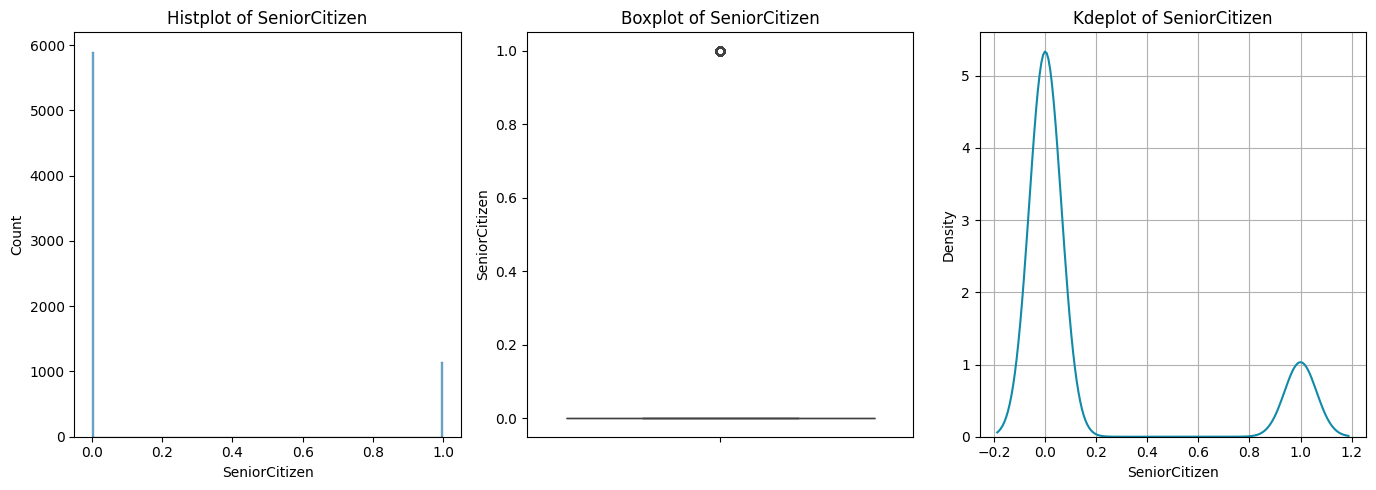

--->tenure<---

The Description of the column : 
count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

The Skewness of the column : 0.24
The Kurtosis of the column : -1.39

==================================================================================================IQR===================================================================================================
The Lower bound : -60.00
The Upper bound : 124.00
The Number of outlier for this column by IQR : 0
The Percentage of outlier for this column by IQR : 0.0
The Graphical Analysis : 



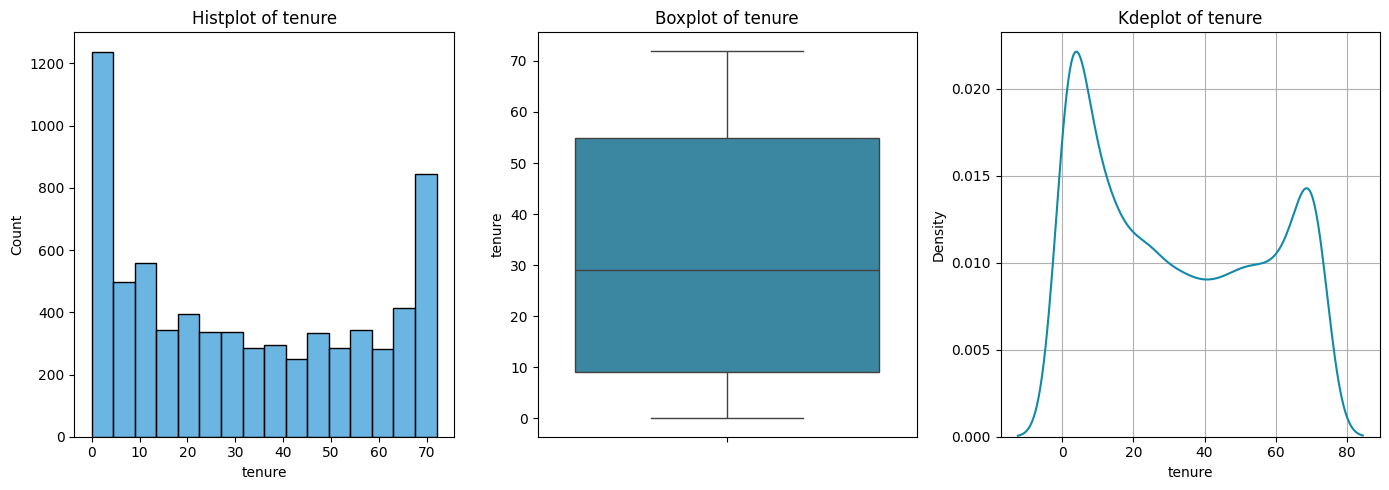

--->MonthlyCharges<---

The Description of the column : 
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

The Skewness of the column : -0.22
The Kurtosis of the column : -1.26

==================================================================================================IQR===================================================================================================
The Lower bound : -46.02
The Upper bound : 171.38
The Number of outlier for this column by IQR : 0
The Percentage of outlier for this column by IQR : 0.0
The Graphical Analysis : 



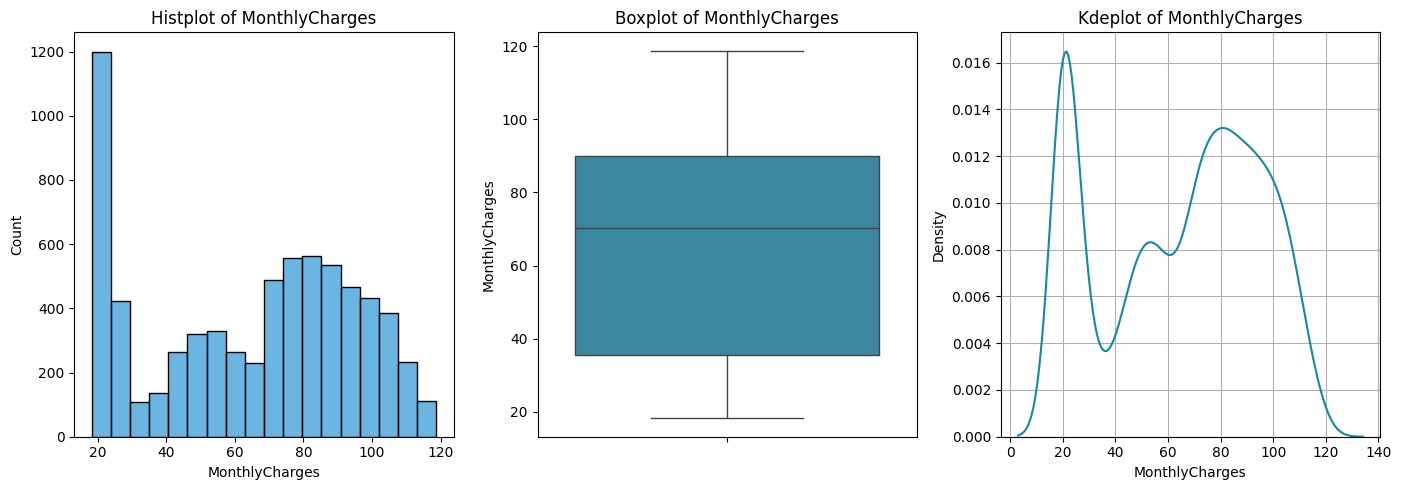

In [531]:
get_numeric_continous_evaluation(df,numeric_columns)

In [532]:
# As we will be using tree based models we dont need to convert the distributions but we will do some scaling later .
# Also we need to do analysis on TotalCharges later as it is continous numeric

In [533]:
# Analyzing other columns and their unique values 

In [534]:
df.select_dtypes('str').columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn'],
      dtype='str')

In [535]:
df.select_dtypes('str').nunique()

gender                 2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
TotalCharges        6531
Churn                  2
dtype: int64

In [536]:
# Now lets create a for loop to analyze all the unique value so we can create a strategy for each of the column   

In [537]:
for x in df.select_dtypes('str').drop(columns=['TotalCharges']).columns : # Dropped TotalCharges cause I know from above it has numerous numeric value and is continous
    print(f'{x} --> {df[x].unique().tolist()}')
# Note we alreadu we have this metadata but in cases where we dont this is a way to find the cardinality

gender --> ['Female', 'Male']
Partner --> ['Yes', 'No']
Dependents --> ['No', 'Yes']
PhoneService --> ['No', 'Yes']
MultipleLines --> ['No phone service', 'No', 'Yes']
InternetService --> ['DSL', 'Fiber optic', 'No']
OnlineSecurity --> ['No', 'Yes', 'No internet service']
OnlineBackup --> ['Yes', 'No', 'No internet service']
DeviceProtection --> ['No', 'Yes', 'No internet service']
TechSupport --> ['No', 'Yes', 'No internet service']
StreamingTV --> ['No', 'Yes', 'No internet service']
StreamingMovies --> ['No', 'Yes', 'No internet service']
Contract --> ['Month-to-month', 'One year', 'Two year']
PaperlessBilling --> ['Yes', 'No']
PaymentMethod --> ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
Churn --> ['No', 'Yes']


In [538]:
df['TotalCharges'].sample(5) #<-- Continous but as str ; need to be converted to float.

5939     550.35
2847     2015.8
5257    3744.05
1240     536.35
3709      50.75
Name: TotalCharges, dtype: str

In [539]:
# Strategy : 
'''
                                                                                Discrete Numeric
gender --> Mapping
Partner , Dependents , PhoneService , PaperlessBilling , Churn --> Mapping
OnlineSecurity  ,  OnlineBackup , DeviceProtection , TechSupport , StreamingTV  ,  StreamingMovies --> Mapping
MultipleLines --> Mapping
InternetService --> OneHotEncoding
Contract --> Heirarchical Mapping
PaymentMethod --> OneHotEncoding

                                                                                Continous Numeric
TotalCharges --> to_numeric
'''

'\n                                                                                Discrete Numeric\ngender --> Mapping\nPartner , Dependents , PhoneService , PaperlessBilling , Churn --> Mapping\nOnlineSecurity  ,  OnlineBackup , DeviceProtection , TechSupport , StreamingTV  ,  StreamingMovies --> Mapping\nMultipleLines --> Mapping\nInternetService --> OneHotEncoding\nContract --> Heirarchical Mapping\nPaymentMethod --> OneHotEncoding\n\n                                                                                Continous Numeric\nTotalCharges --> to_numeric\n'

In [540]:
# No we will first convert the Churn first to mean and then calculate the feature importance based on the mean of their grouping to check whether they 
# will contribute to the model or not.

In [541]:
df['Churn'] = df['Churn'].map({
                    'Yes':1 , 'No':0
})

In [542]:
# Now we will create a for loop to make sure we are calculating the mean and std to analyze the feature's importance

In [543]:
for x in df.select_dtypes('str').drop(columns=['TotalCharges']).columns : print(f'{x} : \n{df.groupby(x)['Churn'].agg(['mean', 'count', 'sum','std'])}\n')

gender : 
            mean  count  sum       std
gender                                
Female  0.269209   3488  939  0.443612
Male    0.261603   3555  930  0.439570

Partner : 
             mean  count   sum       std
Partner                                 
No       0.329580   3641  1200  0.470125
Yes      0.196649   3402   669  0.397523

Dependents : 
                mean  count   sum       std
Dependents                                 
No          0.312791   4933  1543  0.463677
Yes         0.154502   2110   326  0.361515

PhoneService : 
                  mean  count   sum       std
PhoneService                                 
No            0.249267    682   170  0.432906
Yes           0.267096   6361  1699  0.442478

MultipleLines : 
                      mean  count  sum       std
MultipleLines                                   
No                0.250442   3390  849  0.433332
No phone service  0.249267    682  170  0.432906
Yes               0.286099   2971  850  0.452012

In

In [544]:
df[df['InternetService'] == 'No']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
11,Male,0,No,No,16,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),18.95,326.8,0
16,Female,0,No,No,52,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.65,1022.95,0
21,Male,0,Yes,No,12,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),19.80,202.25,0
22,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,1
33,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),20.20,20.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7017,Female,0,No,No,51,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),20.65,1020.75,0
7019,Female,0,No,No,39,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.15,826,0
7020,Male,0,Yes,Yes,12,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,19.20,239,0
7030,Female,0,No,No,2,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.05,39.25,0


In [545]:
# Now we have revised strategy 
'''
1. Feature Selection Findings
Through groupby analysis, we identified which features actually "move the needle" for churn:
The "Dead Weight" (Drop):
gender: Churn rates were nearly identical (~26.1% vs ~26.9%). It provides no predictive signal and adds unnecessary noise.
PhoneService: Redundant. All its information is already captured more accurately in the MultipleLines column.
The "Redundancy" Discovery:
For features like OnlineSecurity, TechSupport, and MultipleLines, the "No [Service]" group and the "No Internet/Phone service" group showed almost identical churn probabilities.
Conclusion: We can merge these into a single 0 (No/Absent) category to simplify the model's input.

'''

'\n1. Feature Selection Findings\nThrough groupby analysis, we identified which features actually "move the needle" for churn:\nThe "Dead Weight" (Drop):\ngender: Churn rates were nearly identical (~26.1% vs ~26.9%). It provides no predictive signal and adds unnecessary noise.\nPhoneService: Redundant. All its information is already captured more accurately in the MultipleLines column.\nThe "Redundancy" Discovery:\nFor features like OnlineSecurity, TechSupport, and MultipleLines, the "No [Service]" group and the "No Internet/Phone service" group showed almost identical churn probabilities.\nConclusion: We can merge these into a single 0 (No/Absent) category to simplify the model\'s input.\n\n'

In [546]:
# Our strategy is same but we have found redundant values and columns which can be removed
'''
Gender and PhoneService are not uniquely identifying the churn rate and will not help the model to differentiate.
Other Columns have a single row No Internet Service and we know that we already have a column for that we will treat those values as no
Same goes with column for No phone Service
'''

'\nGender and PhoneService are not uniquely identifying the churn rate and will not help the model to differentiate.\nOther Columns have a single row No Internet Service and we know that we already have a column for that we will treat those values as no\nSame goes with column for No phone Service\n'

In [547]:
# We will drop the redundant columns
redundant_columns = ['gender','PhoneService']

In [548]:
df = df.drop(columns=redundant_columns) 
# Why are we dropping this values : 
'''
gender : 
            mean  count  sum       std
gender                                
Female  0.269209   3488  939  0.443612
Male    0.261603   3555  930  0.439570 

For Gender Column has not that much std and the mean is similar indicating that both the variables are almost similar meaning we wont be able to distinguish properly

Same in case of the PhoneService Column

PhoneService : 
                  mean  count   sum       std
PhoneService                                 
No            0.249267    682   170  0.432906
Yes           0.267096   6361  1699  0.442478

Also we have the No phone service value in the column Multiple lines so we are gonna handle it there.
'''


'\ngender : \n            mean  count  sum       std\ngender                                \nFemale  0.269209   3488  939  0.443612\nMale    0.261603   3555  930  0.439570 \n\nFor Gender Column has not that much std and the mean is similar indicating that both the variables are almost similar meaning we wont be able to distinguish properly\n\nSame in case of the PhoneService Column\n\nPhoneService : \n                  mean  count   sum       std\nPhoneService                                 \nNo            0.249267    682   170  0.432906\nYes           0.267096   6361  1699  0.442478\n\nAlso we have the No phone service value in the column Multiple lines so we are gonna handle it there.\n'

In [549]:
#Now lets Start Value Conversion

In [550]:
# First we will convert the numeric column TotalCharges into numeric type

In [551]:
# pd.to_numeric(df['TotalCharges']) #  <-- If u run this u will get an error cause the empty value are stored as " " , so we will coerce them and fill with 0

In [552]:
df.apply(lambda x: (x == ' ').sum()) # <-- SHows hidden missing strings that are to be treated as nan

SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [553]:
pd.to_numeric(df['TotalCharges'],errors='coerce')

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [554]:
pd.to_numeric(df['TotalCharges'],errors='coerce').isna().sum() # These are empty values so fill them with 0

np.int64(11)

In [555]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

In [556]:
df['TotalCharges'].isna().sum()

np.int64(11)

In [557]:
df[df['TotalCharges'].isna()] # <-- See that here tenure is zero for each meaning : There should be no charges applied here to customers .

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,0,Yes,Yes,0,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,0,No,Yes,0,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,0
936,0,Yes,Yes,0,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,0
1082,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,0
1340,0,Yes,Yes,0,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0
3331,0,Yes,Yes,0,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0
3826,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0
4380,0,Yes,Yes,0,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0
5218,0,Yes,Yes,0,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0
6670,0,Yes,Yes,0,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,0


In [558]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [559]:
df['TotalCharges'].isna().sum()

np.int64(0)

In [560]:
# Now lets map the categorical dtypes 
'''
'Partner' --> ['Yes', 'No']
'Dependents' --> ['No', 'Yes']
'PaperlessBilling' --> ['Yes', 'No']

MultipleLines --> ['No phone service', 'No', 'Yes']

'OnlineSecurity' --> ['No', 'Yes', 'No internet service']
'OnlineBackup' --> ['Yes', 'No', 'No internet service']
'DeviceProtection' --> ['No', 'Yes', 'No internet service']
'TechSupport' --> ['No', 'Yes', 'No internet service']
'StreamingTV' --> ['No', 'Yes', 'No internet service']
'StreamingMovies' --> ['No', 'Yes', 'No internet service']

Contract --> ['Month-to-month', 'One year', 'Two year']

# One Hot Encoding
'InternetService' --> ['DSL', 'Fiber optic', 'No']
'PaymentMethod' --> ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
'''

"\n'Partner' --> ['Yes', 'No']\n'Dependents' --> ['No', 'Yes']\n'PaperlessBilling' --> ['Yes', 'No']\n\nMultipleLines --> ['No phone service', 'No', 'Yes']\n\n'OnlineSecurity' --> ['No', 'Yes', 'No internet service']\n'OnlineBackup' --> ['Yes', 'No', 'No internet service']\n'DeviceProtection' --> ['No', 'Yes', 'No internet service']\n'TechSupport' --> ['No', 'Yes', 'No internet service']\n'StreamingTV' --> ['No', 'Yes', 'No internet service']\n'StreamingMovies' --> ['No', 'Yes', 'No internet service']\n\nContract --> ['Month-to-month', 'One year', 'Two year']\n\n# One Hot Encoding\n'InternetService' --> ['DSL', 'Fiber optic', 'No']\n'PaymentMethod' --> ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']\n"

In [561]:
# We will group the columns based on the map 
binary_map_1 = {
                    'Yes' : 1 , 'No' : 0
}

binary_map_multiple_lines = {
                                'Yes' : 1 , 'No' : 0 , 'No phone service' : 0
}

binary_map_internet_services = {
                                'Yes' : 1 , 'No' : 0 , 'No internet service' : 0
}

heirarchical_map_contract = {   
                                'Month-to-month' : 1 , 'One year' : 2, 'Two year' : 3
}

In [562]:
# Grouping columns
binary_map_1_columns = ['Partner','Dependents','PaperlessBilling']
binary_map_internet_services_columns = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

In [563]:
# Mapping / Replacing
df[binary_map_1_columns] = df[binary_map_1_columns].replace(binary_map_1).astype('int')
df['MultipleLines'] = df['MultipleLines'].replace(binary_map_multiple_lines).astype('int')
df[binary_map_internet_services_columns] = df[binary_map_internet_services_columns].replace(binary_map_internet_services).astype('int')
df['Contract'] = df['Contract'].replace(heirarchical_map_contract).astype('int')

--->MonthlyCharges<---

The Description of the column : 
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

The Skewness of the column : -0.22
The Kurtosis of the column : -1.26

==================================================================================================IQR===================================================================================================
The Lower bound : -46.02
The Upper bound : 171.38
The Number of outlier for this column by IQR : 0
The Percentage of outlier for this column by IQR : 0.0
The Graphical Analysis : 



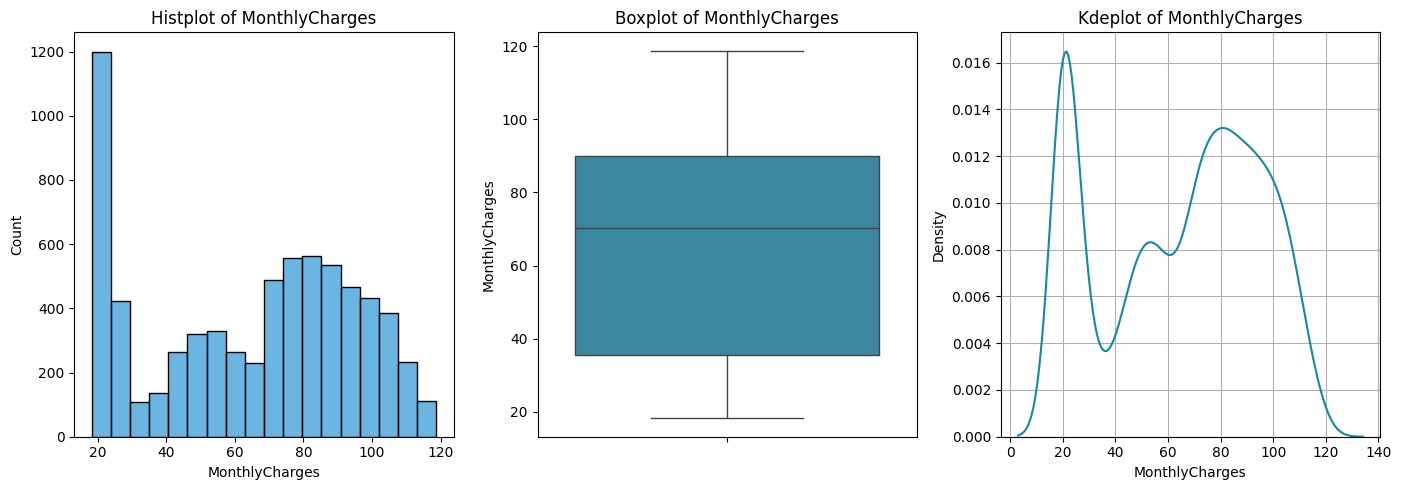

--->tenure<---

The Description of the column : 
count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

The Skewness of the column : 0.24
The Kurtosis of the column : -1.39

==================================================================================================IQR===================================================================================================
The Lower bound : -60.00
The Upper bound : 124.00
The Number of outlier for this column by IQR : 0
The Percentage of outlier for this column by IQR : 0.0
The Graphical Analysis : 



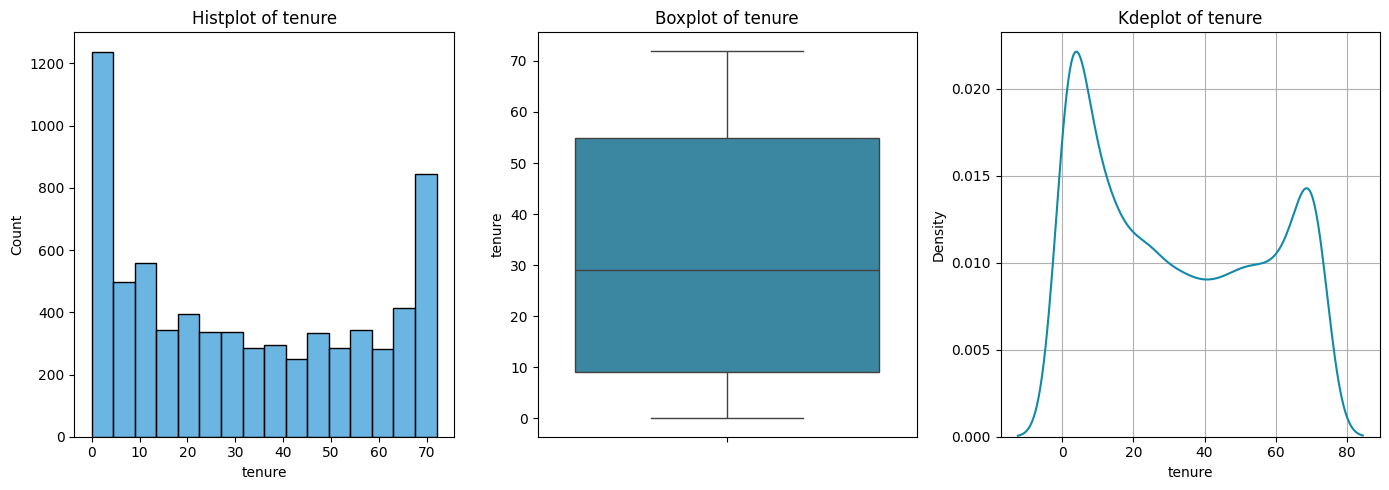

--->TotalCharges<---

The Description of the column : 
count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

The Skewness of the column : 0.96
The Kurtosis of the column : -0.23

==================================================================================================IQR===================================================================================================
The Lower bound : -4683.52
The Upper bound : 8868.67
The Number of outlier for this column by IQR : 0
The Percentage of outlier for this column by IQR : 0.0
The Graphical Analysis : 



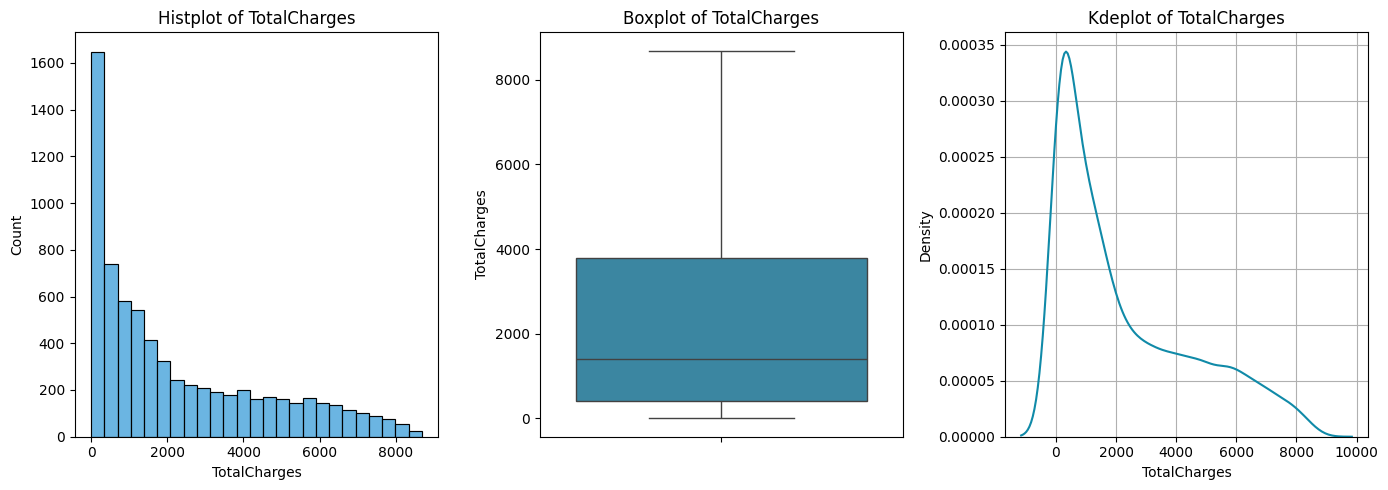

In [564]:
# Now lets reanalyze the continous numeric values : 
continous_numeric_values  =  ['MonthlyCharges','tenure','TotalCharges']
get_numeric_continous_evaluation(df,continous_numeric_values)

In [565]:
# We will split the dataset and then onehotencode to avoid data leaks

In [566]:
# Before we split I WILL create a copy of our dataframe just in case
df_copy = df.copy()

In [567]:
X , y  = df.drop(columns=['Churn']) , df['Churn']

In [568]:
X_train , X_test , y_train , y_test = train_test_split(X,y,stratify=y,random_state=42,test_size=0.3)

In [569]:
columns_to_onc = ['InternetService','PaymentMethod']

In [570]:
col_trf_1 = ColumnTransformer(
                                transformers=[
                                                ('onc_1',OneHotEncoder(sparse_output=False),columns_to_onc)
                                ],
                            remainder = 'passthrough'
)

In [571]:
X_train = col_trf_1.fit_transform(X_train)
X_test = col_trf_1.transform(X_test)

In [572]:
X_train # This is a numpy array and we need to get our features out by the get_feature_names_out() methods

array([[0.0000e+00, 1.0000e+00, 0.0000e+00, ..., 0.0000e+00, 8.0200e+01,
        3.8425e+02],
       [0.0000e+00, 1.0000e+00, 0.0000e+00, ..., 1.0000e+00, 8.6850e+01,
        2.2095e+02],
       [0.0000e+00, 1.0000e+00, 0.0000e+00, ..., 1.0000e+00, 7.5150e+01,
        2.1675e+02],
       ...,
       [0.0000e+00, 1.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.0925e+02,
        7.7077e+03],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 2.0400e+01,
        4.8280e+02],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 2.0650e+01,
        1.0930e+02]], shape=(4930, 22))

In [573]:
col_trf_1.get_feature_names_out()

array(['onc_1__InternetService_DSL', 'onc_1__InternetService_Fiber optic',
       'onc_1__InternetService_No',
       'onc_1__PaymentMethod_Bank transfer (automatic)',
       'onc_1__PaymentMethod_Credit card (automatic)',
       'onc_1__PaymentMethod_Electronic check',
       'onc_1__PaymentMethod_Mailed check', 'remainder__SeniorCitizen',
       'remainder__Partner', 'remainder__Dependents', 'remainder__tenure',
       'remainder__MultipleLines', 'remainder__OnlineSecurity',
       'remainder__OnlineBackup', 'remainder__DeviceProtection',
       'remainder__TechSupport', 'remainder__StreamingTV',
       'remainder__StreamingMovies', 'remainder__Contract',
       'remainder__PaperlessBilling', 'remainder__MonthlyCharges',
       'remainder__TotalCharges'], dtype=object)

In [574]:
X_train = pd.DataFrame(X_train,columns=col_trf_1.get_feature_names_out())
X_test = pd.DataFrame(X_test,columns=col_trf_1.get_feature_names_out())

In [575]:
X_train.head()

,onc_1__InternetService_DSL,onc_1__InternetService_Fiber optic,onc_1__InternetService_No,onc_1__PaymentMethod_Bank transfer (automatic),onc_1__PaymentMethod_Credit card (automatic),onc_1__PaymentMethod_Electronic check,onc_1__PaymentMethod_Mailed check,remainder__SeniorCitizen,remainder__Partner,remainder__Dependents,...,remainder__OnlineSecurity,remainder__OnlineBackup,remainder__DeviceProtection,remainder__TechSupport,remainder__StreamingTV,remainder__StreamingMovies,remainder__Contract,remainder__PaperlessBilling,remainder__MonthlyCharges,remainder__TotalCharges
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,80.20,384.25
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,86.85,220.95
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,75.15,216.75
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,80.55,4847.05
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,98.90,1120.95


In [576]:
X_test.head()

,onc_1__InternetService_DSL,onc_1__InternetService_Fiber optic,onc_1__InternetService_No,onc_1__PaymentMethod_Bank transfer (automatic),onc_1__PaymentMethod_Credit card (automatic),onc_1__PaymentMethod_Electronic check,onc_1__PaymentMethod_Mailed check,remainder__SeniorCitizen,remainder__Partner,remainder__Dependents,...,remainder__OnlineSecurity,remainder__OnlineBackup,remainder__DeviceProtection,remainder__TechSupport,remainder__StreamingTV,remainder__StreamingMovies,remainder__Contract,remainder__PaperlessBilling,remainder__MonthlyCharges,remainder__TotalCharges
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,96.05,1740.70
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,19.05,201.70
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,98.55,1842.80
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,19.70,419.40
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,19.60,808.95


In [577]:
X_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 22 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   onc_1__InternetService_DSL                      4930 non-null   float64
 1   onc_1__InternetService_Fiber optic              4930 non-null   float64
 2   onc_1__InternetService_No                       4930 non-null   float64
 3   onc_1__PaymentMethod_Bank transfer (automatic)  4930 non-null   float64
 4   onc_1__PaymentMethod_Credit card (automatic)    4930 non-null   float64
 5   onc_1__PaymentMethod_Electronic check           4930 non-null   float64
 6   onc_1__PaymentMethod_Mailed check               4930 non-null   float64
 7   remainder__SeniorCitizen                        4930 non-null   float64
 8   remainder__Partner                              4930 non-null   float64
 9   remainder__Dependents                           4930

In [578]:
# In linear models we would have devised some transformations based on the graphical analysis , skewness ,and kurtosis .
# But as we will be using tree based algorithms we will leave it as it is

In [579]:
# Now lets to imbalacedness test in the Target Columns

In [580]:
# Churn Ratio  : 
print(y_train.value_counts())
print(f'The churn ratio - {y_train.value_counts()[0]/len(y_train)}:{y_train.value_counts()[1]/len(y_train)}')

Churn
0    3622
1    1308
Name: count, dtype: int64
The churn ratio - 0.734685598377282:0.2653144016227181


In [581]:
# Now we calculate the ratio of the values in the label set for our models : 
float(y_train.value_counts()[0]/len(y_train)/y_train.value_counts()[1]/len(y_train))
# As see before is imbalanced

1.1393229965344827e-07

In [582]:
# The class weights will be calculated from y_train after spltting to avoid data_leaks
churn_ratio = float(y_train.value_counts()[0]/len(y_train)/y_train.value_counts()[1]/len(y_train))
class_weights = [1,churn_ratio]
class_weights 

[1, 1.1393229965344827e-07]

In [583]:
# Further scalling , pipeling and model training is yet to be done ...